In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib.inline

UsageError: Line magic function `%matplotlib.inline` not found.


In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.MNIST(root='./', train=True, download=True, transform = transform)

In [4]:
test_data = datasets.MNIST(root='./', train=False, download=True, transform = transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Understanding Conv Layer

In [12]:
# ?nn.Conv2d

In [13]:
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1) 
# 1 grayscale, 6 is the filter, 3 is size of kernel, step size is 1

In [8]:
# kernel_size 3 mean 3x3 kernel, kernel size of 4 means 4x4 kernel

In [14]:
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1) 
# this conv layer will take results of the above AFTER it has been passed into a pooling layer
# in_channels = 6 correspond to the previous out_channel of 6

In [15]:
for i, (X_train, y_train) in enumerate(train_data):
    break

In [18]:
X_train.shape # --> 4D batch (batch of 1 image)

torch.Size([1, 28, 28])

In [20]:
x = X_train.view(1,1,28,28) # 1 image of 28 by 28

In [22]:
x = F.relu(conv1(x)) # first conv layer

In [23]:
x.shape

torch.Size([1, 6, 26, 26])

In [24]:
x = F.max_pool2d(x,2,2) # max pooling

In [25]:
x.shape

torch.Size([1, 6, 13, 13])

In [26]:
x = F.relu(conv2(x)) # second conv layer

In [27]:
x = F.max_pool2d(x,2,2)

In [28]:
x.shape

torch.Size([1, 16, 5, 5])

In [29]:
x.view(-1, 16*5*5).shape

torch.Size([1, 400])

# Convolutional Neural Network

In [15]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84,10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 5*5*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [8]:
torch.manual_seed(42)

In [16]:
model = ConvolutionalNetwork()

In [10]:
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [11]:
# total number of parameters = 60074 ... which is much less that multi-layer perceptron
for param in model.parameters():
    print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


In [12]:
criterion = nn.CrossEntropyLoss()

In [13]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)

In [17]:
import time
start_time = time.time()

epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed     

epoch:  0  batch:  600 [  6000/60000]  loss: 2.25386190  accuracy:  10.017%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 2.32516336  accuracy:  10.358%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 2.30425072  accuracy:   9.917%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 2.33820295  accuracy:   9.817%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 2.31255937  accuracy:   9.913%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 2.29890227  accuracy:   9.981%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 2.28501916  accuracy:   9.933%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 2.30917382  accuracy:   9.906%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 2.33056521  accuracy:   9.848%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 2.30441570  accuracy:   9.863%
epoch:  1  batch:  600 [  6000/60000]  loss: 2.27200937  accuracy:  10.067%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 2.31907511  accuracy:   9.992%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 2.30079508  accuracy:  10.056%
epoch:  1  b

# Evaluate

In [22]:
train_losses = list(map(lambda x: x.item(), train_losses))
test_losses = list(map(lambda x: x.item(), test_losses))

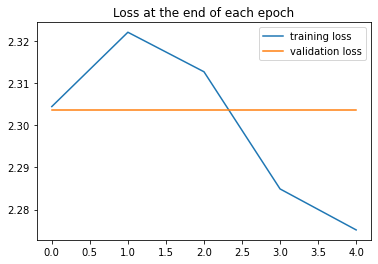

In [23]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

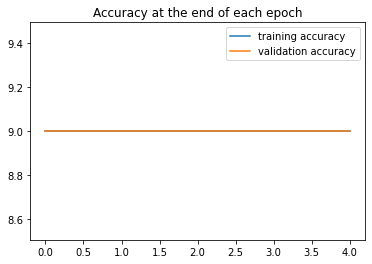

In [31]:
plt.plot([t/600 for t in train_correct], label='training accuracy')
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

# Evaluate Test data

In [32]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

In [33]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)  # we don't flatten the data this time
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 958/10000 =   9.580%


In [34]:
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9]]

[[   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [ 980 1135 1032 1010  982  892  958 1028  974 1009]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0]]
